In [1]:
%load_ext autoreload
%autoreload 2

import os
from dotenv import load_dotenv
load_dotenv()
assert 'OPENAI_API_KEY' in os.environ

In [2]:
import dspy
turbo = dspy.OpenAI(model='gpt-3.5-turbo', max_tokens=4000)
gpt4 = dspy.OpenAI(model='gpt-4', max_tokens=4000)
dspy.settings.configure(lm=turbo)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dspy.TypedPredictor("question -> answer")(question="What is the capital of France?")

Prediction(
    answer='Paris'
)

In [4]:
from dspy.datasets import HotPotQA

# Load the dataset.
dataset = HotPotQA(train_seed=1, train_size=20, eval_seed=2023, dev_size=50, test_size=0)

# Tell DSPy that the 'question' field is the input. Any other fields are labels and/or metadata.
trainset = [x.with_inputs('question') for x in dataset.train]
devset = [x.with_inputs('question') for x in dataset.dev]

len(trainset), len(devset)

(20, 50)

In [5]:
from dspy.evaluate import Evaluate
from dspy.evaluate.metrics import answer_exact_match
from dspy.functional import TypedPredictor, TypedChainOfThought
from dspy.teleprompt.signature_opt_typed import optimize_signature

evaluator = Evaluate(devset=devset, metric=answer_exact_match, num_threads=10, display_progress=True)


In [6]:
result = optimize_signature(
    student=TypedChainOfThought("question -> answer"),
    evaluator=evaluator,
    initial_prompts=6,
    n_iterations=100,
    max_examples=30,
    verbose=True,
    prompt_model=gpt4,
)

Check the final program after optimization

In [ ]:
result.program

Plot the scores over time

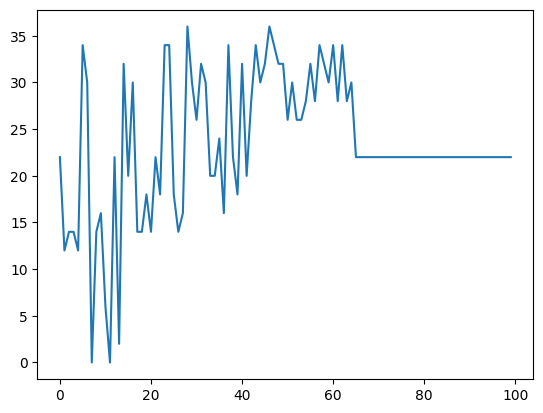

In [ ]:
import matplotlib.pyplot as plt
plt.plot(result.scores)

In [ ]:
gpt4.inspect_history(n=1)





You are an instruction optimizer for large language models.

I will give some task instructions I've tried, along with their corresponding validation scores.
- The instructions are arranged in order based on their scores, where higher scores indicate better quality.
- Your task is to propose a new instruction that will lead a good language model to perform the task even better.
- Be creative, and think out of the box.
- Don't repeat instructions, descriptions and prefixes that have already been attempted.

---

Follow the following format.

Analysis: Consider what made the previous instructions good or bad.
Proposed Signature: A signature that will likely lead to a high score.. Respond with a single JSON object. JSON Schema: {"properties": {"instructions": {"description": "The instructions for the task", "title": "Instructions", "type": "string"}, "question_prefix": {"description": "The prefix for question", "title": "Question Prefix", "type": "string"}, "question_desc": {"descript

# Multi-hop
Let's try a multi-hop example

In [8]:
colbertv2_wiki17_abstracts = dspy.ColBERTv2(url='http://20.102.90.50:2017/wiki17_abstracts')
dspy.settings.configure(rm=colbertv2_wiki17_abstracts)

class GenerateSearchQuery(dspy.Signature):
    """Write a simple search query that will help answer a complex question."""

    context:list[str] = dspy.InputField(desc="may contain relevant facts")
    question = dspy.InputField()
    query = dspy.OutputField()

class GenerateAnswer(dspy.Signature):
    """Answer questions with short factoid answers."""

    context:list[str] = dspy.InputField(desc="may contain relevant facts")
    question = dspy.InputField()
    answer = dspy.OutputField(desc="often between 1 and 5 words")

from dsp.utils import deduplicate

class SimplifiedBaleen(dspy.Module):
    def __init__(self, passages_per_hop=3, max_hops=2):
        super().__init__()

        self.generate_query = [dspy.TypedChainOfThought(GenerateSearchQuery) for _ in range(max_hops)]
        self.retrieve = dspy.Retrieve(k=passages_per_hop)
        self.generate_answer = dspy.TypedChainOfThought(GenerateAnswer)
        self.max_hops = max_hops
    
    def forward(self, question):
        context = []
        
        for hop in range(self.max_hops):
            query = self.generate_query[hop](context=context, question=question).query
            passages = self.retrieve(query).passages
            context = deduplicate(context + passages)

        pred = self.generate_answer(context=context, question=question)
        return dspy.Prediction(context=context, answer=pred.answer)

In [9]:
baleen = SimplifiedBaleen()
baleen(question="What is the capital of France?")

Prediction(
    context=['Paris (disambiguation) | Paris is the largest city and capital of France.', 'Capital (French magazine) | Capital is a monthly French economics and business magazine published in Paris, France.', 'Paris | Paris (] ) is the capital and most populous city of France, with an administrative-limits area of 105 km2 and a 2015 population of 2,229,621. The city is a commune and department, and the capital-heart of the 12,012 km2 Île-de-France "region" (colloquially known as the \'Paris Region\'), whose 12,142,802 2016 population represents roughly 18 percent of the population of France. By the 17th century, Paris had become one of Europe\'s major centres of finance, commerce, fashion, science, and the arts, a position that it retains still today. The Paris Region had a GDP of €649.6 billion (US $763.4 billion) in 2014, accounting for 30.4 percent of the GDP of France. According to official estimates, in 2013-14 the Paris Region had the third-highest GDP in the world an

In [10]:
evaluator(baleen)

Average Metric: 31 / 50  (62.0): 100%|██████████| 50/50 [00:00<00:00, 162.38it/s]

Average Metric: 31 / 50  (62.0%)



/Users/ahle/repos/dspy/dspy/evaluate/evaluate.py:145: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


62.0

In [ ]:

for name, module in baleen.named_sub_modules():
    if getattr(module, "_compiled", False):
        print("Found compiled module", name)

result = optimize_signature(
    student=baleen,
    evaluator=evaluator,
    initial_prompts=6,
    n_iterations=60,
    max_examples=30,
    verbose=True,
    prompt_model=gpt4,
)

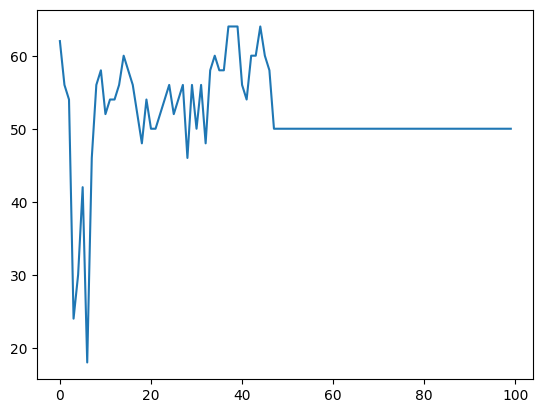

In [15]:
import matplotlib.pyplot as plt
plt.plot(result.scores)

In [59]:
for name, module in baleen.named_sub_modules(TypedPredictor):
    print(name, module)